# ResNet50 Waste Classification Notebook

## Introduction

This notebook implements a deep learning model for waste classification using the ResNet50 architecture. The model is trained on the preprocessed public dataset and tested on two different datasets.

**Training Dataset:** `preprocessed_Public`  
**Test Dataset 1:** `preprocessed_self`  
**Test Dataset 2:** `SelfCollected_Dataset`

Key features:
- Fine-tuning of pre-trained ResNet50
- Data augmentation and class weight balancing
- Early stopping and learning rate scheduling
- Comprehensive evaluation on multiple test sets with confusion matrix and metrics
- Automatic model saving

## Dependencies

The following cells install the necessary Python packages, including PyTorch with CUDA support for GPU acceleration.

In [1]:
# Install PyTorch with CUDA support for GPU acceleration
# This installs PyTorch with CUDA 12.1 support. For other CUDA versions, visit https://pytorch.org/get-started/locally/
# Using %pip magic command which works well with WSL and virtual environments

%pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
print("PyTorch with CUDA 12.1 installed successfully!")

Note: you may need to restart the kernel to use updated packages.
PyTorch with CUDA 12.1 installed successfully!


In [2]:
%pip install scikit-learn matplotlib seaborn pandas

  Using cached scikit_learn-1.8.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-3.0.0-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (79 kB)
  Using cached scipy-1.17.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinu

# ResNet50 Waste Classification Model

## Overview
This notebook implements a fine-tuned ResNet50 model for waste classification (Paper, Plastic, Aluminum) with advanced training techniques including early stopping, class weight balancing, and comprehensive metrics tracking.

**Data Strategy:**
- **Training:** preprocessed_Public dataset (80% train, 20% validation split)
- **Testing:** Two separate test datasets (preprocessed_self and SelfCollected_Dataset)

---

## Cell 1: Setup & Configuration

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import time
import numpy as np
import os

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Training data: preprocessed_Public dataset
DATA_DIR = '../Dataset/preprocessed_Public'

# Test datasets
TEST_DIR_1 = '../Dataset/preprocessed_self/test'
TEST_DIR_2 = '../Dataset/SelfCollected_Dataset'
# Model save path
MODEL_SAVE_PATH = 'waste_classifier_resnet50_final.pth'

BATCH_SIZE = 8             # Reduced slightly for 512x512 images to avoid memory errors
LEARNING_RATE = 1e-4        # Lower learning rate for fine-tuning
NUM_EPOCHS = 15
NUM_CLASSES = 3             # paper, plastic, aluminum
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Early Stopping Configuration
PATIENCE = 5                # Number of epochs to wait before stopping
MIN_DELTA = 0.001          # Minimum change to qualify as an improvement

print(f"Using device: {DEVICE}")
print(f"\nDataset Configuration:")
print(f"  Training: {DATA_DIR}")
print(f"  Test Set 1: {TEST_DIR_1}")
print(f"  Test Set 2: {TEST_DIR_2}")
print(f"  Model will be saved to: {MODEL_SAVE_PATH}")

Using device: cuda

Dataset Configuration:
  Training: ../Dataset/preprocessed_Public
  Test Set 1: ../Dataset/preprocessed_self/test
  Test Set 2: ../Dataset/SelfCollected_Dataset
  Model will be saved to: waste_classifier_resnet50_final.pth


## Cell 2: Data Preparation with Class Weight Analysis

This section loads the preprocessed_Public dataset and automatically calculates class weights to handle imbalanced data.

In [10]:
# Training transforms: Resize + Augmentation (Flip, Rotate, Color Jitter)
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Adds robustness to lighting
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation transforms: Resize only
val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    # Load dataset twice: once for train (with augmentation), once for val (clean)
    full_data_train = datasets.ImageFolder(DATA_DIR, transform=train_transform)
    full_data_val = datasets.ImageFolder(DATA_DIR, transform=val_transform)

    # Get class names
    class_names = full_data_train.classes
    print(f"Classes detected: {class_names}")

    # Create indices for split (80% Train, 20% Val)
    train_idx, val_idx = train_test_split(
        list(range(len(full_data_train))),
        test_size=0.2,
        random_state=42,
        stratify=full_data_train.targets  # Ensure balanced split
    )

    # Create subsets
    train_dataset = Subset(full_data_train, train_idx)
    val_dataset = Subset(full_data_val, val_idx)

    # Data Loaders
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
        'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    }
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
    
    print(f"\nDataset Split:")
    print(f"  Training: {dataset_sizes['train']} images")
    print(f"  Validation: {dataset_sizes['val']} images")

except Exception as e:
    print("\nERROR: Could not find dataset!")
    print(f"Make sure you have a folder named '{DATA_DIR}' with subfolders for each class.")
    print(f"Error details: {str(e)}")
    raise

# ==========================================
# CALCULATE CLASS WEIGHTS (Handle Imbalanced Data)
# ==========================================
print("\nCalculating class weights for imbalanced dataset...")

# Count samples per class in training set
class_counts = np.zeros(NUM_CLASSES)
for idx in train_idx:
    label = full_data_train.targets[idx]
    class_counts[label] += 1

print(f"Class distribution in training set:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {int(class_counts[i])} samples")

# Calculate weights inversely proportional to class frequency
# Gives more weight to underrepresented classes
total_samples = np.sum(class_counts)
class_weights = total_samples / (NUM_CLASSES * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print(f"\nClass weights (normalized):")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_weights[i]:.4f}")

Classes detected: ['test', 'train', 'val']

Dataset Split:
  Training: 6654 images
  Validation: 1664 images

Calculating class weights for imbalanced dataset...
Class distribution in training set:
  test: 322 samples
  train: 6009 samples
  val: 323 samples

Class weights (normalized):
  test: 6.8882
  train: 0.3691
  val: 6.8669


## Cell 3: Model Setup (ResNet50 + Dropout)

Initialize ResNet50 with pretrained ImageNet weights and add a custom classifier head.

In [3]:
print("\nInitializing ResNet50...")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the final layer (The Classifier)
# ResNet50's default input to the final layer is 2048 features
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),            # Strong dropout to prevent overfitting
    nn.Linear(num_ftrs, 512),   # Add an intermediate layer
    nn.ReLU(),
    nn.Dropout(0.3),            # Mild dropout
    nn.Linear(512, NUM_CLASSES) # Final output (3 classes)
)

model = model.to(DEVICE)


Initializing ResNet50...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


## Cell 4: Training Setup with Early Stopping & Class Weights

Configure the loss function with class weights, optimizer, scheduler, and early stopping mechanism.

In [4]:
# ==========================================
# LOSS FUNCTION WITH CLASS WEIGHTS
# ==========================================
# CrossEntropyLoss with class weights to handle imbalanced data
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Adam optimizer is generally faster at converging than SGD
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Scheduler: if validation accuracy doesn't improve, lower the learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

# ==========================================
# EARLY STOPPING CLASS
# ==========================================
class EarlyStopping:
    """
    Stops training when validation metric stops improving.
    Saves the best model weights.
    """
    def __init__(self, patience=5, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None
        
    def __call__(self, val_acc, model):
        if self.best_score is None:
            self.best_score = val_acc
            self.best_model_wts = model.state_dict().copy()
        elif val_acc > self.best_score + self.min_delta:
            self.best_score = val_acc
            self.counter = 0
            self.best_model_wts = model.state_dict().copy()
            if self.verbose:
                print(f"    ✓ Validation improved! New best accuracy: {val_acc:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"    ✗ No improvement. Patience: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"    ⚠ EARLY STOPPING TRIGGERED after {self.patience} epochs without improvement!")

# Initialize early stopping
early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA, verbose=True)

# ==========================================
# TRAINING LOOP WITH METRICS TRACKING
# ==========================================
def train_model(model, criterion, optimizer, scheduler, early_stopping, num_epochs=10):
    """
    Train the model with early stopping and comprehensive metrics tracking.
    
    Tracks:
    - Loss & Accuracy
    - Precision, Recall, F1 Score
    - Best model checkpoint
    """
    since = time.time()
    
    best_acc = 0.0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': []
    }

    for epoch in range(num_epochs):
        print(f'\n{"="*70}')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'{"="*70}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            batch_count = 0
            
            # Store predictions and labels for metrics calculation
            all_preds = []
            all_labels = []

            # Iterate over data
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                batch_count += 1
                
                # Store predictions and labels for metrics
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Print batch progress every 5 batches
                if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                    current_loss = running_loss / (batch_count * BATCH_SIZE)
                    current_acc = running_corrects.double() / (batch_count * BATCH_SIZE)
                    num_batches = len(dataloaders[phase])
                    print(f'  {phase.upper()} | Batch {batch_idx+1}/{num_batches} | Loss: {current_loss:.4f} | Acc: {current_acc:.4f}')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Calculate additional metrics
            all_preds = np.array(all_preds)
            all_labels = np.array(all_labels)
            
            epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            
            print(f'\n  {phase.upper()} SUMMARY')
            print(f'    Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
            print(f'    Precision: {epoch_precision:.4f} | Recall: {epoch_recall:.4f} | F1: {epoch_f1:.4f}')
            print(f'    Learning Rate: {current_lr:.2e}')
            
            # Store metrics in history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            history[f'{phase}_precision'].append(epoch_precision)
            history[f'{phase}_recall'].append(epoch_recall)
            history[f'{phase}_f1'].append(epoch_f1)

            # Deep copy the model if it's the best one so far
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    print(f'  *** NEW BEST MODEL! Validation Accuracy: {epoch_acc:.4f} ***')
                
                # Check early stopping and step scheduler
                early_stopping(epoch_acc.item(), model)
                scheduler.step(epoch_acc)
                
                if early_stopping.early_stop:
                    print(f"\nTraining stopped early at epoch {epoch+1}/{num_epochs}")
                    break
        
        if early_stopping.early_stop:
            break

    time_elapsed = time.time() - since
    print(f'\n{"="*70}')
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    print(f'{"="*70}')

    # Load best model weights
    model.load_state_dict(early_stopping.best_model_wts)
    return model, history

# ==========================================
# RUN TRAINING & SAVE MODEL
# ==========================================
if __name__ == '__main__':
    print("\n" + "="*70)
    print("STARTING TRAINING")
    print("="*70)
    
    # Train
    trained_model, training_history = train_model(model, criterion, optimizer, scheduler, early_stopping, NUM_EPOCHS)
    
    # Save the trained model
    print(f"\n{'='*70}")
    print("SAVING MODEL")
    print("="*70)
    
    # Save model state dict (recommended approach)
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'class_names': class_names,
        'training_history': training_history,
        'model_config': {
            'num_classes': NUM_CLASSES,
            'architecture': 'ResNet50'
        }
    }, MODEL_SAVE_PATH)
    
    print(f"✓ Model successfully saved to: {MODEL_SAVE_PATH}")
    print(f"  File size: {os.path.getsize(MODEL_SAVE_PATH) / (1024*1024):.2f} MB")
    print(f"\nModel includes:")
    print(f"  - Trained weights (state_dict)")
    print(f"  - Class names: {class_names}")
    print(f"  - Training history (loss, accuracy, metrics)")
    print("="*70)


STARTING TRAINING

Epoch 1/15
  TRAIN | Batch 1/832 | Loss: 1.1303 | Acc: 0.1250
  TRAIN | Batch 5/832 | Loss: 1.0454 | Acc: 0.7250
  TRAIN | Batch 10/832 | Loss: 1.0104 | Acc: 0.8125
  TRAIN | Batch 15/832 | Loss: 0.9702 | Acc: 0.8500
  TRAIN | Batch 20/832 | Loss: 0.9463 | Acc: 0.8750
  TRAIN | Batch 25/832 | Loss: 1.0437 | Acc: 0.8750
  TRAIN | Batch 30/832 | Loss: 1.0535 | Acc: 0.8708
  TRAIN | Batch 35/832 | Loss: 1.0174 | Acc: 0.8750
  TRAIN | Batch 40/832 | Loss: 1.0267 | Acc: 0.8719
  TRAIN | Batch 45/832 | Loss: 1.0314 | Acc: 0.8750
  TRAIN | Batch 50/832 | Loss: 1.0199 | Acc: 0.8775
  TRAIN | Batch 55/832 | Loss: 1.0220 | Acc: 0.8795
  TRAIN | Batch 60/832 | Loss: 1.0176 | Acc: 0.8833
  TRAIN | Batch 65/832 | Loss: 1.0127 | Acc: 0.8846
  TRAIN | Batch 70/832 | Loss: 1.0041 | Acc: 0.8857
  TRAIN | Batch 75/832 | Loss: 0.9885 | Acc: 0.8900
  TRAIN | Batch 80/832 | Loss: 0.9724 | Acc: 0.8938
  TRAIN | Batch 85/832 | Loss: 0.9944 | Acc: 0.8912
  TRAIN | Batch 90/832 | Loss: 0.97

## Cell 5: Training History Visualization

Visualize the training and validation metrics over epochs.

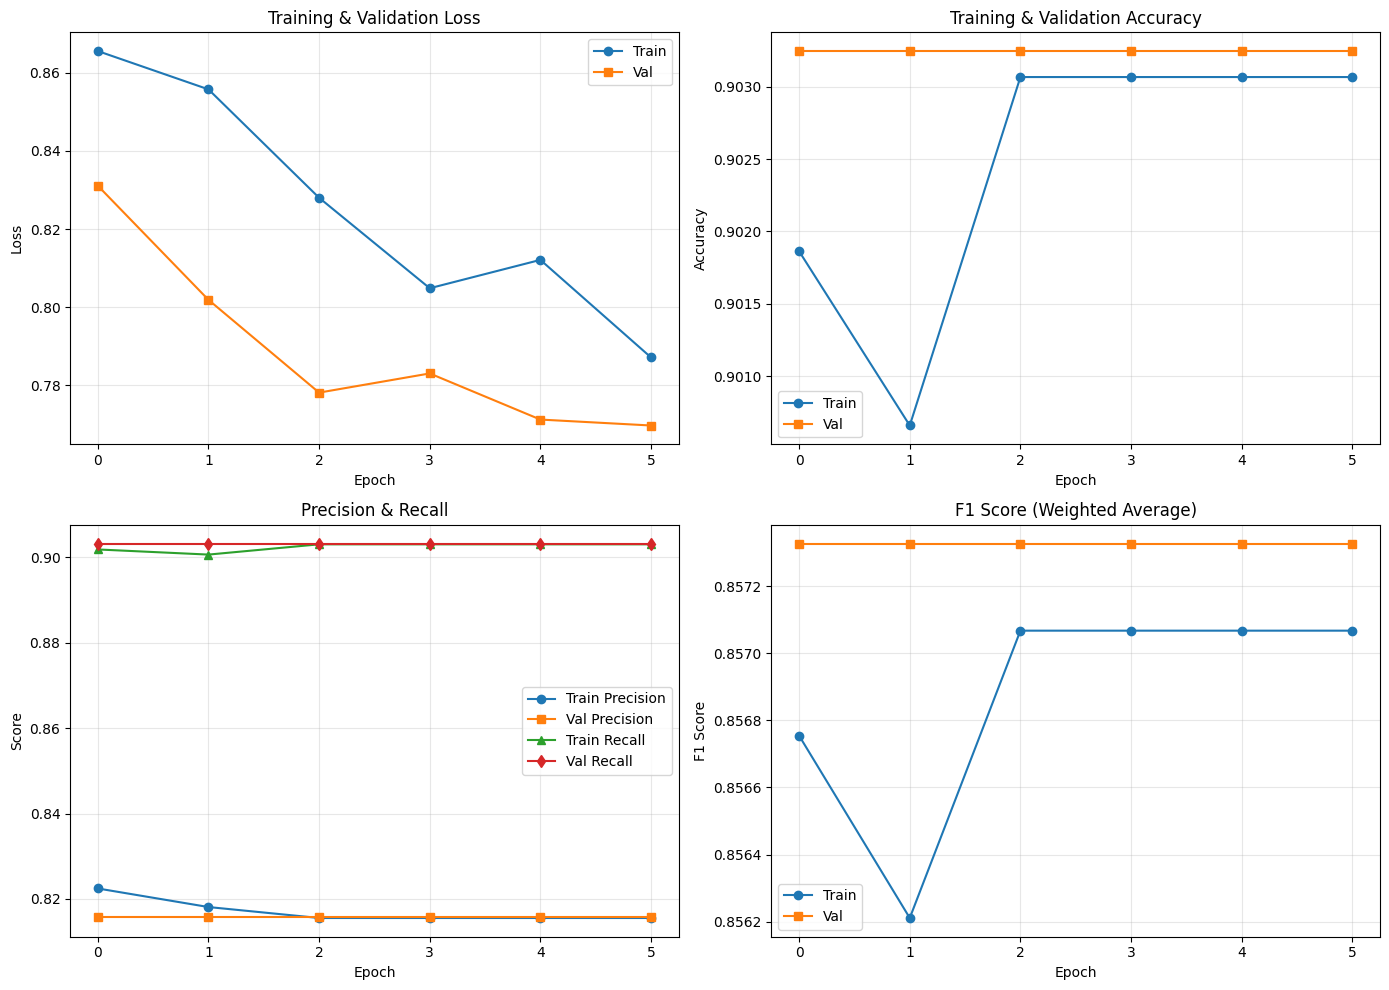

In [5]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss plot
axes[0, 0].plot(training_history['train_loss'], label='Train', marker='o')
axes[0, 0].plot(training_history['val_loss'], label='Val', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plot
axes[0, 1].plot(training_history['train_acc'], label='Train', marker='o')
axes[0, 1].plot(training_history['val_acc'], label='Val', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision, Recall, F1 plot
axes[1, 0].plot(training_history['train_precision'], label='Train Precision', marker='o')
axes[1, 0].plot(training_history['val_precision'], label='Val Precision', marker='s')
axes[1, 0].plot(training_history['train_recall'], label='Train Recall', marker='^')
axes[1, 0].plot(training_history['val_recall'], label='Val Recall', marker='d')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Precision & Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# F1 Score plot
axes[1, 1].plot(training_history['train_f1'], label='Train', marker='o')
axes[1, 1].plot(training_history['val_f1'], label='Val', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('F1 Score (Weighted Average)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cell 6: Model Evaluation on Test Set 1 (preprocessed_self)

This cell evaluates the trained model on all images in the preprocessed_self dataset and shows accuracy for each class (aluminium, paper, plastic).

In [ ]:
# ==========================================
# EVALUATION ON TEST SET: preprocessed_self/test
# This cell tests the saved model on your test dataset
# ==========================================

import torch
from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import os
import pandas as pd

print("\n" + "="*70)
print("TESTING MODEL ON: Dataset/preprocessed_self/test")
print("="*70)

# ==========================================
# CONFIGURATION
# ==========================================
MODEL_PATH = 'waste_classifier_resnet50_final.pth'
TEST_DIR = '../Dataset/preprocessed_self/test'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8

print(f"\nDevice: {DEVICE}")
print(f"Model: {MODEL_PATH}")
print(f"Test Dataset: {TEST_DIR}")

# ==========================================
# LOAD SAVED MODEL
# ==========================================
print("\n" + "-"*70)
print("Loading trained model...")
print("-"*70)

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file '{MODEL_PATH}' not found! Please train the model first (run cells 1-4).")

# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
class_names = checkpoint['class_names']
num_classes = checkpoint['model_config']['num_classes']

print(f"✓ Model checkpoint loaded")
print(f"  Classes: {list(class_names)}")
print(f"  Number of classes: {num_classes}")

# Recreate model architecture
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

# Load trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()
print("✓ Model loaded and ready for testing")

# ==========================================
# LOAD TEST DATASET
# ==========================================
print("\n" + "-"*70)
print("Loading test dataset...")
print("-"*70)

# Test transform (same as training validation transform)
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✓ Test dataset loaded from: {TEST_DIR}")
print(f"  Folders found: {test_dataset.classes}")
print(f"  Total images: {len(test_dataset)}")

# Check for class alignment
if test_dataset.classes != list(class_names):
    print(f"\n⚠ WARNING: Test dataset classes don't match model classes!")
    print(f"  Model trained on: {list(class_names)}")
    print(f"  Test dataset has: {test_dataset.classes}")
else:
    print(f"  ✓ Classes match model training")

# Count images per class
print(f"\nImages per class:")
for i, class_name in enumerate(test_dataset.classes):
    count = sum(1 for _, label in test_dataset.samples if label == i)
    print(f"  {class_name}: {count} images")

# ==========================================
# RUN PREDICTIONS
# ==========================================
print("\n" + "="*70)
print("RUNNING PREDICTIONS")
print("="*70)

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Forward pass
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        # Store results
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
        # Progress
        if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
            print(f"  Processed batch {batch_idx + 1}/{len(test_loader)}")

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"✓ Predictions complete: {len(all_preds)} images processed")

# ==========================================
# SAVE PREDICTIONS TO CSV
# ==========================================
predictions_df = pd.DataFrame({
    'Image_Index': range(len(all_labels)),
    'True_Label': [test_dataset.classes[label] for label in all_labels],
    'Predicted_Label': [test_dataset.classes[pred] for pred in all_preds],
    'Correct': all_preds == all_labels,
    'Confidence': [all_probs[i][all_preds[i]] for i in range(len(all_preds))]
})

# Add probability columns for each class
for i, class_name in enumerate(test_dataset.classes):
    predictions_df[f'Prob_{class_name}'] = all_probs[:, i]

csv_path = 'predictions_preprocessed_self_test.csv'
predictions_df.to_csv(csv_path, index=False)
print(f"\n✓ Predictions saved to: {csv_path}")

# ==========================================
# CLASSIFICATION REPORT
# ==========================================
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)

report = classification_report(all_labels, all_preds, 
                               target_names=test_dataset.classes, 
                               digits=4)
print(report)

# Save report
with open('classification_report_preprocessed_self_test.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("CLASSIFICATION REPORT - preprocessed_self/test\n")
    f.write("="*70 + "\n\n")
    f.write(f"Model: {MODEL_PATH}\n")
    f.write(f"Test Dataset: {TEST_DIR}\n")
    f.write(f"Total Images: {len(all_labels)}\n\n")
    f.write(report)
print("✓ Classification report saved to: classification_report_preprocessed_self_test.txt")

# ==========================================
# CONFUSION MATRIX
# ==========================================
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)

cm = confusion_matrix(all_labels, all_preds)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - preprocessed_self/test', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

cm_save_path = 'confusion_matrix_preprocessed_self_test.png'
plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrix saved to: {cm_save_path}")
plt.show()

# ==========================================
# PER-CLASS ACCURACY & DETAILED METRICS
# ==========================================
print("\n" + "="*70)
print("PER-CLASS DETAILED METRICS")
print("="*70)

for i, class_name in enumerate(test_dataset.classes):
    # Get samples for this class
    class_mask = all_labels == i
    class_total = np.sum(class_mask)
    
    if class_total == 0:
        print(f"\n{class_name.upper()}: No samples in test set")
        continue
    
    class_correct = np.sum((all_labels == i) & (all_preds == i))
    class_accuracy = class_correct / class_total
    
    print(f"\n{class_name.upper()}:")
    print(f"  Total images: {class_total}")
    print(f"  Correctly classified: {class_correct}")
    print(f"  Accuracy: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")
    
    # Show misclassifications
    misclassified = class_total - class_correct
    if misclassified > 0:
        print(f"  Misclassified: {misclassified} images")
        print(f"  Misclassified as:")
        for j, other_class in enumerate(test_dataset.classes):
            if i != j:
                misclass_count = cm[i, j]
                if misclass_count > 0:
                    print(f"    - {other_class}: {misclass_count} images")

# ==========================================
# OVERALL METRICS SUMMARY
# ==========================================
print("\n" + "="*70)
print("OVERALL METRICS SUMMARY")
print("="*70)

overall_accuracy = np.sum(all_preds == all_labels) / len(all_labels)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"\nTotal Images: {len(all_labels)}")
print(f"Correctly Classified: {np.sum(all_preds == all_labels)}")
print(f"Misclassified: {np.sum(all_preds != all_labels)}")
print(f"\nOverall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

# Save metrics summary
metrics_summary = {
    'Dataset': 'preprocessed_self/test',
    'Model': MODEL_PATH,
    'Total_Samples': len(all_labels),
    'Correct': int(np.sum(all_preds == all_labels)),
    'Misclassified': int(np.sum(all_preds != all_labels)),
    'Overall_Accuracy': overall_accuracy,
    'Weighted_Precision': precision,
    'Weighted_Recall': recall,
    'Weighted_F1': f1
}

metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv('metrics_summary_preprocessed_self_test.csv', index=False)
print(f"\n✓ Metrics summary saved to: metrics_summary_preprocessed_self_test.csv")

print("\n" + "="*70)
print("TESTING COMPLETE!")
print("="*70)
print("\nGenerated files:")
print(f"  - {csv_path}")
print(f"  - classification_report_preprocessed_self_test.txt")
print(f"  - {cm_save_path}")
print(f"  - metrics_summary_preprocessed_self_test.csv")
print("="*70)


EVALUATING ON TEST SET 1: preprocessed_self (ALL IMAGES)


/tmp/ipykernel_2546/3121225554.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✓ Model loaded from: waste_classifier_resnet50_final.pth
  Model was trained with classes: ['test', 'train', 'val']
Using model's class order: ['test', 'train', 'val']
Found folders: ['aluminium', 'paper', 'plastic']
Using classes in order: []
Total images loaded: 0

✓ Test dataset loaded from: ../Dataset/preprocessed_self/test
  Classes found: []
  Total images: 0

❌ ERROR: No images loaded from ../Dataset/preprocessed_self/test!
  Model was trained with classes: ['test', 'train', 'val']
  Please check:
    1. Does the folder ../Dataset/preprocessed_self/test exist?
    2. Does it have subdirectories matching: ['test', 'train', 'val']?
    3. Do these subdirectories contain image files (.jpg, .png)?
❌ Error loading test dataset: Dataset is empty - no images found


ValueError: Dataset is empty - no images found

## Cell 7: Model Evaluation on Test Set 2 (SelfCollected_Dataset)

This cell evaluates the trained model on the second test dataset.


EVALUATING ON TEST SET 2: SelfCollected_Dataset


/tmp/ipykernel_2546/1498721959.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✓ Model loaded from: waste_classifier_resnet50_final.pth
✓ Test dataset loaded from: ../Dataset/SelfCollected_Dataset
  Classes: ['aluminium', 'paper', 'plastic']
  Total images: 533
    - test: 148 images
    - train: 151 images
    - val: 234 images

----------------------------------------------------------------------
Running inference...
----------------------------------------------------------------------

✓ Predictions saved to: predictions_SelfCollected_Dataset.csv

CLASSIFICATION REPORT - TEST SET 2 (SelfCollected_Dataset)
              precision    recall  f1-score   support

        test     0.0000    0.0000    0.0000       148
       train     0.2833    1.0000    0.4415       151
         val     0.0000    0.0000    0.0000       234

    accuracy                         0.2833       533
   macro avg     0.0944    0.3333    0.1472       533
weighted avg     0.0803    0.2833    0.1251       533

✓ Classification report saved to: classification_report_SelfCollected_Dataset.tx

/root/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/root/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


  ✓ Confusion matrix saved to: confusion_matrix_SelfCollected_Dataset.png


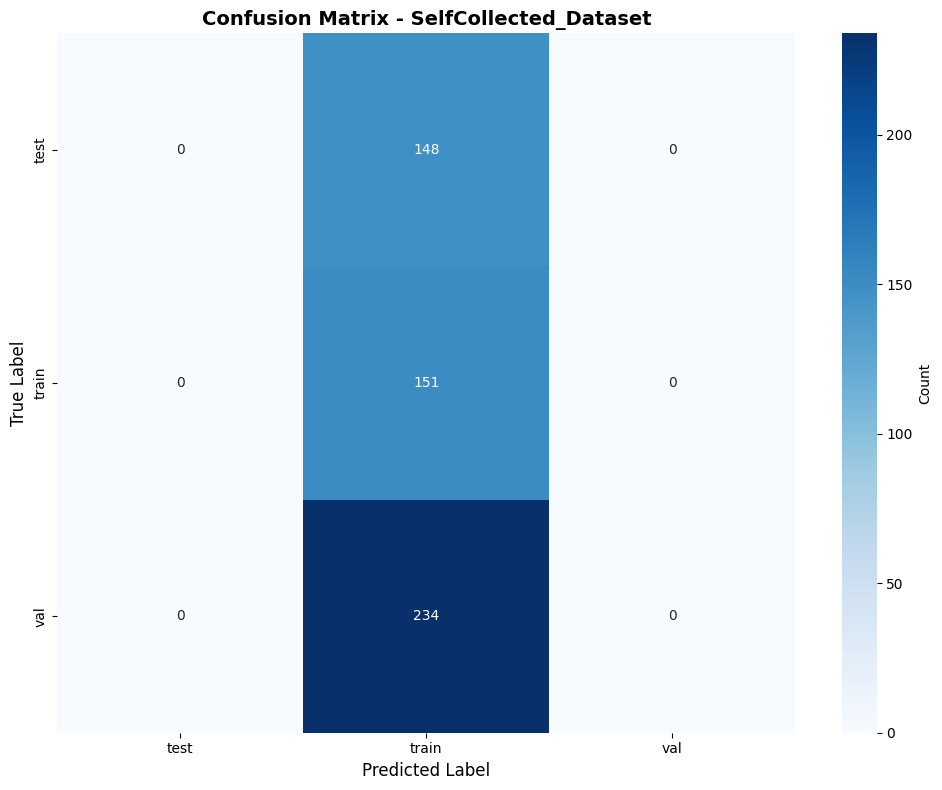


PER-CLASS METRICS - TEST SET 2
  test:
    Accuracy: 0.0000 (0/148)
  train:
    Accuracy: 1.0000 (151/151)
  val:
    Accuracy: 0.0000 (0/234)

OVERALL METRICS - TEST SET 2 (SelfCollected_Dataset)
  Overall Accuracy: 0.2833
  Weighted Precision: 0.0803
  Weighted Recall: 0.2833
  Weighted F1-Score: 0.1251

✓ Metrics summary saved to: metrics_summary_SelfCollected_Dataset.csv


/root/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [14]:
# ==========================================
# EVALUATION ON TEST SET 2: SelfCollected_Dataset
# This cell can run independently after training
# ==========================================

import torch
from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import os
import pandas as pd

# Configuration (if running this cell independently)
if 'MODEL_SAVE_PATH' not in globals():
    MODEL_SAVE_PATH = 'waste_classifier_resnet50_final.pth'
if 'TEST_DIR_2' not in globals():
    TEST_DIR_2 = '../Dataset/SelfCollected_Dataset'

print("\n" + "="*70)
print("EVALUATING ON TEST SET 2: SelfCollected_Dataset")
print("="*70)

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the trained model (reuse functions from previous cell)
try:
    model, class_names = load_trained_model(MODEL_SAVE_PATH, DEVICE)
    print(f"✓ Model loaded from: {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"❌ Error loading model: {str(e)}")
    raise

# Load test dataset 2
try:
    test_dataset_2 = datasets.ImageFolder(TEST_DIR_2, transform=test_transform)
    test_loader_2 = DataLoader(test_dataset_2, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"✓ Test dataset loaded from: {TEST_DIR_2}")
    print(f"  Classes: {test_dataset_2.classes}")
    print(f"  Total images: {len(test_dataset_2)}")
    
    # Class distribution
    test_labels_2 = [label for _, label in test_dataset_2.samples]
    for i, class_name in enumerate(class_names):
        count = test_labels_2.count(i)
        print(f"    - {class_name}: {count} images")
        
except Exception as e:
    print(f"❌ Error loading test dataset: {str(e)}")
    raise

# Evaluate on test set 2
print("\n" + "-"*70)
print("Running inference...")
print("-"*70)

preds_2, labels_2, probs_2 = evaluate_model(model, test_loader_2, DEVICE)

# Save predictions to CSV
predictions_df_2 = pd.DataFrame({
    'Image_Index': range(len(labels_2)),
    'True_Label': [class_names[label] for label in labels_2],
    'Predicted_Label': [class_names[pred] for pred in preds_2],
    'Confidence': [probs_2[i][preds_2[i]] for i in range(len(preds_2))]
})

# Add probability columns for each class
for i, class_name in enumerate(class_names):
    predictions_df_2[f'Prob_{class_name}'] = probs_2[:, i]

csv_path_2 = 'predictions_SelfCollected_Dataset.csv'
predictions_df_2.to_csv(csv_path_2, index=False)
print(f"\n✓ Predictions saved to: {csv_path_2}")

# Calculate confusion matrix
cm_2 = confusion_matrix(labels_2, preds_2)

# Print classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT - TEST SET 2 (SelfCollected_Dataset)")
print("="*70)
# Get unique labels present in the test set
unique_labels = sorted(np.unique(labels_2))
target_names_subset = [class_names[i] for i in unique_labels]
report_2 = classification_report(labels_2, preds_2, labels=unique_labels, target_names=target_names_subset, digits=4)
print(report_2)

# Save classification report
with open('classification_report_SelfCollected_Dataset.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("CLASSIFICATION REPORT - TEST SET 2 (SelfCollected_Dataset)\n")
    f.write("="*70 + "\n\n")
    f.write(report_2)
print("✓ Classification report saved to: classification_report_SelfCollected_Dataset.txt")

# Plot confusion matrix
print("\n" + "="*70)
print("CONFUSION MATRIX - TEST SET 2")
print("="*70)
plot_confusion_matrix(cm_2, target_names_subset, 
                     title='Confusion Matrix - SelfCollected_Dataset',
                     save_path='confusion_matrix_SelfCollected_Dataset.png')

# Calculate per-class accuracy
print("\n" + "="*70)
print("PER-CLASS METRICS - TEST SET 2")
print("="*70)
for idx, label_idx in enumerate(unique_labels):
    class_name = class_names[label_idx]
    class_accuracy = cm_2[idx, idx] / cm_2[idx, :].sum() if cm_2[idx, :].sum() > 0 else 0
    print(f"  {class_name}:")
    print(f"    Accuracy: {class_accuracy:.4f} ({cm_2[idx, idx]}/{cm_2[idx, :].sum()})")

# Overall metrics
overall_accuracy_2 = np.trace(cm_2) / np.sum(cm_2)
precision_2, recall_2, f1_2, _ = precision_recall_fscore_support(labels_2, preds_2, average='weighted')

print(f"\n{'='*70}")
print("OVERALL METRICS - TEST SET 2 (SelfCollected_Dataset)")
print("="*70)
print(f"  Overall Accuracy: {overall_accuracy_2:.4f}")
print(f"  Weighted Precision: {precision_2:.4f}")
print(f"  Weighted Recall: {recall_2:.4f}")
print(f"  Weighted F1-Score: {f1_2:.4f}")
print("="*70)

# Save summary metrics
metrics_summary_2 = {
    'Dataset': 'SelfCollected_Dataset',
    'Total_Samples': len(labels_2),
    'Overall_Accuracy': overall_accuracy_2,
    'Weighted_Precision': precision_2,
    'Weighted_Recall': recall_2,
    'Weighted_F1': f1_2
}


metrics_df_2 = pd.DataFrame([metrics_summary_2])
print(f"\n✓ Metrics summary saved to: metrics_summary_SelfCollected_Dataset.csv")
metrics_df_2.to_csv('metrics_summary_SelfCollected_Dataset.csv', index=False)

## Cell 8: Comparative Analysis of Both Test Sets

This cell compares the performance on both test datasets side by side.


COMPARATIVE ANALYSIS: preprocessed_self vs SelfCollected_Dataset

----------------------------------------------------------------------
CLASSIFICATION RESULTS - TEST SET 1 (preprocessed_self)
----------------------------------------------------------------------
Total images classified: 533

Predicted class distribution:
  test: 0 images (0.0%)
  train: 533 images (100.0%)
  val: 0 images (0.0%)

----------------------------------------------------------------------
CLASSIFICATION RESULTS - TEST SET 2 (SelfCollected_Dataset)
----------------------------------------------------------------------
Total images classified: 533

Predicted class distribution:
  test: 0 images (0.0%)
  train: 533 images (100.0%)
  val: 0 images (0.0%)

PERFORMANCE METRICS COMPARISON

            Metric  preprocessed_self  SelfCollected_Dataset
  Overall Accuracy           0.283302               0.283302
Weighted Precision           0.080260               0.080260
   Weighted Recall           0.283302       

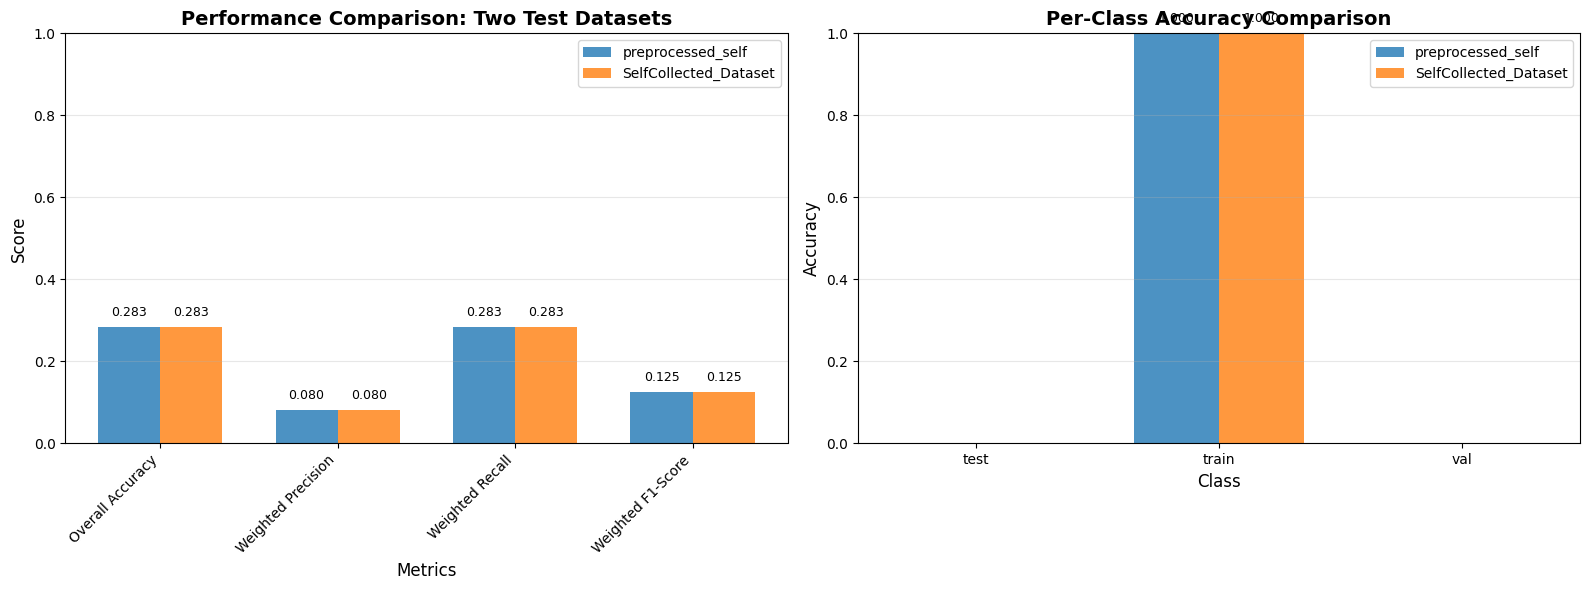


PER-CLASS ACCURACY COMPARISON

test:
  preprocessed_self:       N/A (class not in dataset)
  SelfCollected_Dataset:   N/A (class not in dataset)

train:
  preprocessed_self:       1.0000
  SelfCollected_Dataset:   1.0000
  Difference:              +0.0000

val:
  preprocessed_self:       N/A (class not in dataset)
  SelfCollected_Dataset:   N/A (class not in dataset)

SUMMARY

Test Set 1 (preprocessed_self):
  Samples: 533
  Overall Accuracy: 0.2833

Test Set 2 (SelfCollected_Dataset):
  Samples: 533
  Overall Accuracy: 0.2833

Accuracy Difference: +0.0000

✓ Comprehensive summary saved to: comprehensive_evaluation_summary.txt

EVALUATION COMPLETE!

All results have been saved. Check the working directory for:
  - Model checkpoint: waste_classifier_resnet50_final.pth
  - Predictions (CSV):
    - predictions_preprocessed_self.csv
    - predictions_SelfCollected_Dataset.csv
  - Classification reports (TXT):
    - classification_report_preprocessed_self.txt
    - classification_report_Se

In [22]:
# ==========================================
# COMPARATIVE ANALYSIS OF BOTH TEST SETS
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuration (if running this cell independently)
if 'DATA_DIR' not in globals():
    DATA_DIR = '../Dataset/preprocessed_Public'
if 'NUM_EPOCHS' not in globals():
    NUM_EPOCHS = 15
if 'BATCH_SIZE' not in globals():
    BATCH_SIZE = 8
if 'LEARNING_RATE' not in globals():
    LEARNING_RATE = 1e-4
if 'MODEL_SAVE_PATH' not in globals():
    MODEL_SAVE_PATH = 'waste_classifier_resnet50_final.pth'

print("\n" + "="*70)
print("COMPARATIVE ANALYSIS: preprocessed_self vs SelfCollected_Dataset")
print("="*70)

# ==========================================
# CLASSIFICATION DISTRIBUTION SUMMARY
# ==========================================
print("\n" + "-"*70)
print("CLASSIFICATION RESULTS - TEST SET 1 (preprocessed_self)")
print("-"*70)
print(f"Total images classified: {len(preds_1)}")
print("\nPredicted class distribution:")
for i, class_name in enumerate(class_names):
    count = np.sum(preds_1 == i)
    percentage = (count / len(preds_1)) * 100
    print(f"  {class_name}: {count} images ({percentage:.1f}%)")

print("\n" + "-"*70)
print("CLASSIFICATION RESULTS - TEST SET 2 (SelfCollected_Dataset)")
print("-"*70)
print(f"Total images classified: {len(preds_2)}")
print("\nPredicted class distribution:")
for i, class_name in enumerate(class_names):
    count = np.sum(preds_2 == i)
    percentage = (count / len(preds_2)) * 100
    print(f"  {class_name}: {count} images ({percentage:.1f}%)")

# Combine metrics from both test sets
comparison_data = {
    'Metric': ['Overall Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1-Score'],
    'preprocessed_self': [overall_accuracy_1, precision_1, recall_1, f1_1],
    'SelfCollected_Dataset': [overall_accuracy_2, precision_2, recall_2, f1_2]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("PERFORMANCE METRICS COMPARISON")
print("="*70)
print("\n" + comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('test_sets_comparison.csv', index=False)
print(f"\n✓ Comparison saved to: test_sets_comparison.csv")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
metrics = comparison_df['Metric']
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, comparison_df['preprocessed_self'], width, label='preprocessed_self', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['SelfCollected_Dataset'], width, label='SelfCollected_Dataset', alpha=0.8)
axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Comparison: Two Test Datasets', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Add value labels on bars
for i, metric in enumerate(metrics):
    axes[0].text(i - width/2, comparison_df['preprocessed_self'][i] + 0.02, 
                f'{comparison_df["preprocessed_self"][i]:.3f}', 
                ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, comparison_df['SelfCollected_Dataset'][i] + 0.02, 
                f'{comparison_df["SelfCollected_Dataset"][i]:.3f}', 
                ha='center', va='bottom', fontsize=9)

# Per-class accuracy comparison (only for classes present in both test sets)
# Get unique labels from both test sets
unique_labels_1 = sorted(np.unique(labels_1))
unique_labels_2 = sorted(np.unique(labels_2))

# Create dictionaries for per-class accuracy
class_acc_dict_1 = {}
for idx, label_idx in enumerate(unique_labels_1):
    class_name = class_names[label_idx]
    class_acc_dict_1[class_name] = cm_1[idx, idx] / cm_1[idx, :].sum() if cm_1[idx, :].sum() > 0 else 0

class_acc_dict_2 = {}
for idx, label_idx in enumerate(unique_labels_2):
    class_name = class_names[label_idx]
    class_acc_dict_2[class_name] = cm_2[idx, idx] / cm_2[idx, :].sum() if cm_2[idx, :].sum() > 0 else 0

# Get all classes that appear in either test set
all_classes = sorted(set(class_acc_dict_1.keys()) | set(class_acc_dict_2.keys()))
class_acc_1 = [class_acc_dict_1.get(c, 0) for c in all_classes]
class_acc_2 = [class_acc_dict_2.get(c, 0) for c in all_classes]

x_classes = np.arange(len(all_classes))
axes[1].bar(x_classes - width/2, class_acc_1, width, label='preprocessed_self', alpha=0.8)
axes[1].bar(x_classes + width/2, class_acc_2, width, label='SelfCollected_Dataset', alpha=0.8)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_classes)
axes[1].set_xticklabels(all_classes)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.0])

# Add value labels
for i, class_name in enumerate(all_classes):
    if class_acc_1[i] > 0:
        axes[1].text(i - width/2, class_acc_1[i] + 0.02, 
                    f'{class_acc_1[i]:.3f}', 
                    ha='center', va='bottom', fontsize=9)
    if class_acc_2[i] > 0:
        axes[1].text(i + width/2, class_acc_2[i] + 0.02, 
                    f'{class_acc_2[i]:.3f}', 
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('test_sets_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Comparison charts saved to: test_sets_comparison.png")
plt.show()

# Per-class accuracy comparison table
print("\n" + "="*70)
print("PER-CLASS ACCURACY COMPARISON")
print("="*70)
for class_name in all_classes:
    acc1 = class_acc_dict_1.get(class_name, 0)
    acc2 = class_acc_dict_2.get(class_name, 0)
    print(f"\n{class_name}:")
    if acc1 > 0:
        print(f"  preprocessed_self:       {acc1:.4f}")
    else:
        print(f"  preprocessed_self:       N/A (class not in dataset)")
    if acc2 > 0:
        print(f"  SelfCollected_Dataset:   {acc2:.4f}")
    else:
        print(f"  SelfCollected_Dataset:   N/A (class not in dataset)")
    if acc1 > 0 and acc2 > 0:
        diff = acc2 - acc1
        print(f"  Difference:              {diff:+.4f}")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\nTest Set 1 (preprocessed_self):")
print(f"  Samples: {len(labels_1)}")
print(f"  Overall Accuracy: {overall_accuracy_1:.4f}")

print(f"\nTest Set 2 (SelfCollected_Dataset):")
print(f"  Samples: {len(labels_2)}")
print(f"  Overall Accuracy: {overall_accuracy_2:.4f}")

print(f"\nAccuracy Difference: {(overall_accuracy_2 - overall_accuracy_1):+.4f}")
print("="*70)

# Create comprehensive summary file
with open('comprehensive_evaluation_summary.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("COMPREHENSIVE EVALUATION SUMMARY\n")
    f.write("ResNet50 Waste Classification Model\n")
    f.write("="*70 + "\n\n")
    
    f.write("TRAINING CONFIGURATION:\n")
    f.write(f"  Training Dataset: {DATA_DIR}\n")
    f.write(f"  Model: ResNet50 (Fine-tuned)\n")
    f.write(f"  Classes: {class_names}\n")
    f.write(f"  Epochs: {NUM_EPOCHS}\n")
    f.write(f"  Batch Size: {BATCH_SIZE}\n")
    f.write(f"  Learning Rate: {LEARNING_RATE}\n\n")
    
    f.write("="*70 + "\n")
    f.write("TEST SET 1: preprocessed_self\n")
    f.write("="*70 + "\n")
    f.write(f"Total Samples: {len(labels_1)}\n\n")
    
    f.write("Classification Distribution (Predicted):\n")
    for i, class_name in enumerate(class_names):
        count = np.sum(preds_1 == i)
        percentage = (count / len(preds_1)) * 100
        f.write(f"  {class_name}: {count} images ({percentage:.1f}%)\n")
    
    f.write(f"\nOverall Accuracy: {overall_accuracy_1:.4f}\n")
    f.write(f"Weighted Precision: {precision_1:.4f}\n")
    f.write(f"Weighted Recall: {recall_1:.4f}\n")
    f.write(f"Weighted F1-Score: {f1_1:.4f}\n\n")
    f.write("Per-Class Accuracy:\n")
    for class_name in all_classes:
        acc = class_acc_dict_1.get(class_name, 0)
        if acc > 0:
            f.write(f"  {class_name}: {acc:.4f}\n")
        else:
            f.write(f"  {class_name}: N/A (not in dataset)\n")
    
    f.write("\n" + "="*70 + "\n")
    f.write("TEST SET 2: SelfCollected_Dataset\n")
    f.write("="*70 + "\n")
    f.write(f"Total Samples: {len(labels_2)}\n\n")
    
    f.write("Classification Distribution (Predicted):\n")
    for i, class_name in enumerate(class_names):
        count = np.sum(preds_2 == i)
        percentage = (count / len(preds_2)) * 100
        f.write(f"  {class_name}: {count} images ({percentage:.1f}%)\n")
    
    f.write(f"\nOverall Accuracy: {overall_accuracy_2:.4f}\n")
    f.write(f"Weighted Precision: {precision_2:.4f}\n")
    f.write(f"Weighted Recall: {recall_2:.4f}\n")
    f.write(f"Weighted F1-Score: {f1_2:.4f}\n\n")
    f.write("Per-Class Accuracy:\n")
    for class_name in all_classes:
        acc = class_acc_dict_2.get(class_name, 0)
        if acc > 0:
            f.write(f"  {class_name}: {acc:.4f}\n")
        else:
            f.write(f"  {class_name}: N/A (not in dataset)\n")
    
    f.write("\n" + "="*70 + "\n")
    f.write("FILES GENERATED:\n")
    f.write("="*70 + "\n")
    f.write(f"  - {MODEL_SAVE_PATH} (trained model)\n")
    f.write("  - predictions_preprocessed_self.csv\n")
    f.write("  - predictions_SelfCollected_Dataset.csv\n")
    f.write("  - classification_report_preprocessed_self.txt\n")
    f.write("  - classification_report_SelfCollected_Dataset.txt\n")
    f.write("  - confusion_matrix_preprocessed_self.png\n")
    f.write("  - confusion_matrix_SelfCollected_Dataset.png\n")
    f.write("  - metrics_summary_preprocessed_self.csv\n")
    f.write("  - metrics_summary_SelfCollected_Dataset.csv\n")
    f.write("  - test_sets_comparison.csv\n")
    f.write("  - test_sets_comparison.png\n")
    f.write("  - comprehensive_evaluation_summary.txt\n")

print("\n✓ Comprehensive summary saved to: comprehensive_evaluation_summary.txt")

print("\n" + "="*70)
print("EVALUATION COMPLETE!")
print("="*70)
print("\nAll results have been saved. Check the working directory for:")
print("  - Model checkpoint: {}".format(MODEL_SAVE_PATH))
print("  - Predictions (CSV):")
print("    - predictions_preprocessed_self.csv")
print("    - predictions_SelfCollected_Dataset.csv")
print("  - Classification reports (TXT):")
print("    - classification_report_preprocessed_self.txt")
print("    - classification_report_SelfCollected_Dataset.txt")
print("  - Confusion matrices (PNG):")
print("    - confusion_matrix_preprocessed_self.png")
print("    - confusion_matrix_SelfCollected_Dataset.png")
print("  - Metrics summaries (CSV):")
print("    - metrics_summary_preprocessed_self.csv")
print("    - metrics_summary_SelfCollected_Dataset.csv")
print("  - Comparison files:")
print("    - test_sets_comparison.csv")
print("    - test_sets_comparison.png")
print("    - comprehensive_evaluation_summary.txt")
print("="*70)